In [2]:
import jupyter_utils as j

j.reload(j)

In [3]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
import xgboost
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score, recall_score, precision_recall_fscore_support

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import fbeta_score, recall_score

from time import time

from matplotlib import pyplot as plt

import matplotlib

matplotlib.style.use('ggplot')

j.apply_options(pd)
j.reload(j)

%matplotlib inline

/home/bruno/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
data = pd.read_csv('final_curated_dataset.csv') 

pd.set_option('use_inf_as_na', True)
data = data.dropna()
data = data.drop(list(filter(lambda c: len(c) == 2, data.columns)), axis = 1)

data.head(10)

,canceled,male,paid,avg_daily_actions,avg_session_duration,n_actions,n_added_to_playlist,n_ads,n_days,n_dislikes,n_downgrades,n_errors,n_friends,n_help,n_home,n_likes,n_sess,n_settings,n_songs,n_upgrades,session_avg_actions,session_avg_added_playlist,session_avg_ads,session_avg_dislikes,session_avg_errors,session_avg_friends,session_avg_help,session_avg_home,session_avg_likes,session_avg_playback,session_avg_settings,session_avg_songs,session_avg_time_away,time_window
0,0,1,1,56.8333,8.0648,682,20,3,12,10,1,3,12,5,27,25,9,4,557,0,17.6695,0.5182,0.0777,0.2591,0.0777,0.3109,0.1295,0.6995,0.6477,1.0168,0.1036,14.4310,152.1053,1255.4403
1,1,0,1,58.1667,4.3539,349,12,2,6,2,0,1,7,1,14,10,7,1,287,1,17.4340,0.5995,0.0999,0.0999,0.0500,0.3497,0.0500,0.6994,0.4995,1.0207,0.0500,14.3369,65.0248,410.1672
2,0,1,0,14.0000,1.3151,28,0,0,2,0,0,0,1,0,3,0,2,1,22,0,18.2410,0.0000,0.0000,0.0000,0.0000,0.6515,0.0000,1.9544,0.0000,2.1093,0.6515,14.3322,298.9264,300.4614
3,0,1,0,29.5000,2.7901,531,9,30,18,6,0,0,9,1,26,21,15,1,408,0,19.5147,0.3308,1.1025,0.2205,0.0000,0.3308,0.0368,0.9555,0.7718,1.0401,0.0368,14.9943,90.7683,1297.9658
4,0,1,0,26.8333,3.5426,322,16,16,12,4,0,1,5,3,15,14,12,2,241,0,16.3729,0.8136,0.8136,0.2034,0.0508,0.2542,0.1525,0.7627,0.7119,0.8451,0.1017,12.2542,106.0787,1186.5322
5,1,1,0,77.2273,11.9687,1699,45,11,22,16,0,1,21,7,67,72,20,13,1407,1,17.7966,0.4714,0.1152,0.1676,0.0105,0.2200,0.0733,0.7018,0.7542,1.0674,0.1362,14.7380,53.9937,1121.3475
6,0,1,1,95.7333,13.6353,1436,27,0,15,18,1,3,18,8,53,69,11,10,1191,0,17.3166,0.3256,0.0000,0.2171,0.0362,0.2171,0.0965,0.6391,0.8321,1.1070,0.1206,14.3622,115.0595,1233.5211
7,0,1,1,57.2500,7.1337,687,19,0,12,7,0,0,12,1,35,20,9,1,569,0,16.5323,0.4572,0.0000,0.1685,0.0000,0.2888,0.0241,0.8423,0.4813,0.9550,0.0241,13.6927,139.8815,1160.6067
8,0,1,0,87.5000,6.8268,175,3,10,2,2,0,0,1,1,5,9,2,1,141,0,16.6174,0.2849,0.9496,0.1899,0.0000,0.0950,0.0950,0.4748,0.8546,0.9444,0.0950,13.3889,535.3506,545.8817
9,0,1,0,26.0000,1.6787,78,1,6,3,0,0,0,1,1,5,3,3,1,59,0,19.7802,0.2536,1.5216,0.0000,0.0000,0.2536,0.2536,1.2680,0.7608,1.0470,0.2536,14.9620,90.5168,184.9769


In [5]:
from sklearn.preprocessing import Normalizer, RobustScaler, StandardScaler

# Remove binary features
features_to_normalize = list(data.drop(['canceled', 'male', 'paid'], axis = 1).columns)

_x = data.copy()
_x[features_to_normalize] = Normalizer().fit_transform(_x[features_to_normalize]) 

_x.head(10)

,canceled,male,paid,avg_daily_actions,avg_session_duration,n_actions,n_added_to_playlist,n_ads,n_days,n_dislikes,n_downgrades,n_errors,n_friends,n_help,n_home,n_likes,n_sess,n_settings,n_songs,n_upgrades,session_avg_actions,session_avg_added_playlist,session_avg_ads,session_avg_dislikes,session_avg_errors,session_avg_friends,session_avg_help,session_avg_home,session_avg_likes,session_avg_playback,session_avg_settings,session_avg_songs,session_avg_time_away,time_window
0,0,1,1,0.0368,0.0052,0.4420,0.0130,0.0019,0.0078,0.0065,0.0006,0.0019,0.0078,0.0032,0.0175,0.0162,0.0058,0.0026,0.3610,0.0000,0.0115,0.0003,0.0001,0.0002,0.0001,0.0002,0.0001,0.0005,0.0004,0.0007,0.0001,0.0094,0.0986,0.8137
1,1,0,1,0.0942,0.0071,0.5653,0.0194,0.0032,0.0097,0.0032,0.0000,0.0016,0.0113,0.0016,0.0227,0.0162,0.0113,0.0016,0.4649,0.0016,0.0282,0.0010,0.0002,0.0002,0.0001,0.0006,0.0001,0.0011,0.0008,0.0017,0.0001,0.0232,0.1053,0.6644
2,0,1,0,0.0328,0.0031,0.0657,0.0000,0.0000,0.0047,0.0000,0.0000,0.0000,0.0023,0.0000,0.0070,0.0000,0.0047,0.0023,0.0516,0.0000,0.0428,0.0000,0.0000,0.0000,0.0000,0.0015,0.0000,0.0046,0.0000,0.0049,0.0015,0.0336,0.7013,0.7049
3,0,1,0,0.0201,0.0019,0.3625,0.0061,0.0205,0.0123,0.0041,0.0000,0.0000,0.0061,0.0007,0.0177,0.0143,0.0102,0.0007,0.2785,0.0000,0.0133,0.0002,0.0008,0.0002,0.0000,0.0002,0.0000,0.0007,0.0005,0.0007,0.0000,0.0102,0.0620,0.8861
4,0,1,0,0.0213,0.0028,0.2559,0.0127,0.0127,0.0095,0.0032,0.0000,0.0008,0.0040,0.0024,0.0119,0.0111,0.0095,0.0016,0.1915,0.0000,0.0130,0.0006,0.0006,0.0002,0.0000,0.0002,0.0001,0.0006,0.0006,0.0007,0.0001,0.0097,0.0843,0.9430
5,1,1,0,0.0311,0.0048,0.6853,0.0182,0.0044,0.0089,0.0065,0.0000,0.0004,0.0085,0.0028,0.0270,0.0290,0.0081,0.0052,0.5675,0.0004,0.0072,0.0002,0.0000,0.0001,0.0000,0.0001,0.0000,0.0003,0.0003,0.0004,0.0001,0.0059,0.0218,0.4523
6,0,1,1,0.0427,0.0061,0.6400,0.0120,0.0000,0.0067,0.0080,0.0004,0.0013,0.0080,0.0036,0.0236,0.0308,0.0049,0.0045,0.5308,0.0000,0.0077,0.0001,0.0000,0.0001,0.0000,0.0001,0.0000,0.0003,0.0004,0.0005,0.0001,0.0064,0.0513,0.5497
7,0,1,1,0.0389,0.0048,0.4665,0.0129,0.0000,0.0081,0.0048,0.0000,0.0000,0.0081,0.0007,0.0238,0.0136,0.0061,0.0007,0.3864,0.0000,0.0112,0.0003,0.0000,0.0001,0.0000,0.0002,0.0000,0.0006,0.0003,0.0006,0.0000,0.0093,0.0950,0.7881
8,0,1,0,0.1091,0.0085,0.2182,0.0037,0.0125,0.0025,0.0025,0.0000,0.0000,0.0012,0.0012,0.0062,0.0112,0.0025,0.0012,0.1758,0.0000,0.0207,0.0004,0.0012,0.0002,0.0000,0.0001,0.0001,0.0006,0.0011,0.0012,0.0001,0.0167,0.6674,0.6805
9,0,1,0,0.1125,0.0073,0.3376,0.0043,0.0260,0.0130,0.0000,0.0000,0.0000,0.0043,0.0043,0.0216,0.0130,0.0130,0.0043,0.2554,0.0000,0.0856,0.0011,0.0066,0.0000,0.0000,0.0011,0.0011,0.0055,0.0033,0.0045,0.0011,0.0648,0.3918,0.8007


In [6]:
from sklearn.metrics import make_scorer

# beta - The recall weight 
beta_scorer = make_scorer(fbeta_score, average='binary', beta = 2)

def get_beta_score(y_test, y_predict):
    return fbeta_score(y_test, y_predict, average = 'binary', labels = [1, 0], beta = 2)

## Default configurations for all models

In [7]:
RANDOM_STATE = 42
TEST_SIZE = .35
N_FOLDS = 3
N_JOBS = -1

In [8]:
def plot_roc_curve(y_test, y_predictions, model, action = 'Training'):
    
    fp, tp, _ = roc_curve(y_test, y_predictions)
    auc = roc_auc_score(y_test, y_predictions)
    
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fp, tp, color = 'darkorange', label = model.__class__.__name__)
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'{action} - ROC curve (area = {np.around(auc, 4)})')
    plt.legend(loc = 'best')
    plt.show()
    
def plot_metrics(y_test, y_predictions):
    
    auc = roc_auc_score(y_test, y_predictions)
    cm = confusion_matrix(y_test, y_predictions, labels = [1, 0])
    
    tn = cm[1, 1]
    tp = cm[0, 0]
    fp = cm[1, 0]
    fn = cm[0, 1]
    
    total = np.sum(cm) # tn + tp + fn + fp
    accuracy = (tp + tn) / total
    precision = (tp) / (tp + fp)
    recall = (tp) / (tp + fn) 

    beta = get_beta_score(y_test, y_predictions)
    
    print(cm)
    print('')
    print('accuracy.................%7.4f' % accuracy)
    print('precision................%7.4f' % precision)
    print('recall...................%7.4f' % recall)
    print('auc......................%7.4f' % auc)
    print('beta.....................%7.4f' % beta)
    print('F1 macro.................%7.4f' % f1_score(y_test, y_predictions, average = 'macro'))
    print('F1 micro.................%7.4f' % f1_score(y_test, y_predictions, average = 'micro'))
    print('F1 weighted..............%7.4f' % f1_score(y_test, y_predictions, average = 'weighted'))
    # f1 = (2 * tp ) / (2 * tp + fp + fn) - f1_score with average 'binary'
    print('F1 binary................%7.4f' % f1_score(y_test, y_predictions, average = 'binary', labels = [1, 0]))
    
def get_metrics(y_test, y_predictions):
    
    auc = roc_auc_score(y_test.values, y_predictions)
    cm = confusion_matrix(y_test.values, y_predictions, labels = [1, 0])
    
    tn = cm[1, 1]
    tp = cm[0, 0]
    fp = cm[1, 0]
    fn = cm[0, 1]
    
    total = np.sum(cm)
    accuracy = (tp + tn) / total
    precision = (tp) / (tp + fp)
    recall = (tp) / (tp + fn) 

    beta = get_beta_score(y_test.values, y_predictions)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'auc': auc,
        'binary': f1_score(y_test.values, y_predictions, average = 'binary', labels = [1, 0]),
        'beta': beta,
        'tp': int(tp),
        'fn': int(fn),
        'fp': int(fp),
        'tn': int(tn),
        'y_test': y_test.values,
        'y_predictions': y_predictions
    }

def train_model_with_metrics(df, label, classifier, normalizer): 
    
    s = time()

    x = df.drop([label], axis = 1)
    y = df[label]

    X_train, X_test, y_train, y_test = split(x, y, test_size = TEST_SIZE, random_state = RANDOM_STATE)
    
    model = classifier.fit(X_train, y_train)
        
    # Testing
    y_predicted = model.predict(X_test)
    metrics = get_metrics(y_test, y_predicted)
    
    _training_data = {  
        'normalizer': normalizer
    }
    
    if type(model) == GridSearchCV:
        _training_data['params'] = model.best_estimator_.get_params()
        _training_data['model_name'] = model.best_estimator_.__class__.__name__
    else:
        _training_data['params'] = model.get_params()
        _training_data['model_name'] = model.__class__.__name__
    
    _training_data['execution_time_ms'] = time() - s
    
    return { **metrics, **_training_data } 
    
def train_model(df, label, classifier): 

    x = df.drop([label], axis = 1)
    y = df[label]

    X_train, X_test, y_train, y_test = split(x, y, test_size = TEST_SIZE, random_state = RANDOM_STATE)
    
    model = classifier.fit(X_train, y_train)
    
    # Train
    y_predicted = model.predict(X_train)
    plot_roc_curve(y_train, y_predicted, model)
    plot_metrics(y_train, y_predicted)
    
    # Testing
    y_predicted = model.predict(X_test)
    plot_roc_curve(y_test, y_predicted, model, 'Testing')
    plot_metrics(y_test, y_predicted)
    
    return model

def train_gs_gradient_boosting(df, label, normalizer):
     
    grid_values = {
        'loss': ['deviance', 'exponential'],
        'subsample': [.75, .99, 1],
        'min_samples_split' : [2],
        'n_estimators': [100, 200, 300, 400],
        'learning_rate': [.25, .1, .05, 0.02, .01, 0.015, 0.001],
        'max_depth': [3, 4, 6, 8, 10],
        'max_features': [7, 14, 25, 30, 32],
        'min_samples_leaf': [1, 3, 5, 9]
    }
    
    gb = GradientBoostingClassifier(n_estimators = 200, 
                                    max_depth = 6, 
                                    learning_rate = 0.1, 
                                    random_state = RANDOM_STATE, 
                                    n_iter_no_change = 10)
    
    gb_gs = GridSearchCV(gb, 
                         param_grid = grid_values, 
                         verbose = 3, 
                         n_jobs = N_JOBS, 
                         cv = N_FOLDS, 
                         iid = False, 
                         scoring = beta_scorer)
     
    return train_model_with_metrics(df, label, gb_gs, normalizer)   
 
def train_gs_logistic_regression(df, label, normalizer):
    
    grid_values = {
        'class_weight': ['balanced', { 0 : .3, 1: .7 }, { 0 : .4, 1: .6 }],
        'solver' : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
        'C': [.1, .5, 1, 1.5, 2, 4, 6, 8, 10, 12, 20], 
        'max_iter': [50, 100, 150, 200, 300, 400, 500, 800, 1000, 2000]
    }

    lr = LogisticRegression(n_jobs = -1, random_state = RANDOM_STATE)
    lg_gs = GridSearchCV(lr, 
                         param_grid = grid_values, 
                         return_train_score = True, 
                         verbose = 3, 
                         n_jobs = N_JOBS, 
                         cv = N_FOLDS, 
                         scoring = beta_scorer, 
                         iid = False)
    
    return train_model_with_metrics(df, label, lg_gs, normalizer)
    
def train_gs_random_forest(df, label, normalizer):
    
    rf = RandomForestClassifier(n_jobs = N_JOBS, 
                                random_state = RANDOM_STATE)
    
    grid_values = {
        'class_weight': ['balanced'],
        'criterion': ['gini', 'entropy'],
        'bootstrap': [True, False],
         # 'oob_score': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 8, 10],
        'n_estimators': [10, 100, 200, 400]
    }
    
    rf_gs = GridSearchCV(rf, 
                         param_grid = grid_values, 
                         return_train_score = True, 
                         verbose = 3, 
                         n_jobs = N_JOBS, 
                         cv = 3, 
                         scoring = beta_scorer, 
                         iid = False)
    
    return train_model_with_metrics(df, label, rf_gs, normalizer)

def train_gs_extra_trees(df, label, normalizer):
       
    grid_values = {
        'class_weight': ['balanced', { 0 : .3, 1: .7 }, { 0 : .4, 1: .6 }],
        'criterion': ['gini', 'entropy'],
        'bootstrap': [True, False],
         # 'oob_score': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_leaf': [1, 2, 4, 8, 10],
        'min_samples_split': [1.0, 2, 5, 8, 10],
        'n_estimators': [10, 50, 100, 200, 400]
    }
    
    cl = ExtraTreesClassifier(n_jobs = N_JOBS, 
                              class_weight = 'balanced', 
                              bootstrap = True,
                              criterion = 'gini', 
                              random_state = RANDOM_STATE, 
                              max_features = .55, 
                              min_samples_leaf = 2, 
                              min_samples_split = 16, 
                              n_estimators = 100)
    
    cl_gs = GridSearchCV(cl, 
                         param_grid = grid_values, 
                         return_train_score = True, 
                         verbose = 3, 
                         n_jobs = N_JOBS, 
                         cv = N_FOLDS, 
                         scoring = beta_scorer, 
                         iid = False)
        
    return train_model_with_metrics(df, label, cl_gs, normalizer)

def train_gs_xgb(df, label, normalizer):
    
    grid_values = {
        'n_estimators': [100, 250, 500],
        'max_depth': [3, 4, 5, 6, 9, 12],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.9, 1],
        'learning_rate': [0.25, .1, 0.05, 0.02, 0.01, 0.015, 0.001]
    }

    xgbc = xgboost.XGBClassifier(silent = False, predictor = 'cpu_predictor')
    xgbc_gs = GridSearchCV(xgbc, 
                           param_grid = grid_values, 
                           return_train_score = True, 
                           verbose = 3, 
                           n_jobs = N_JOBS, 
                           cv = N_FOLDS, 
                           scoring = beta_scorer, 
                           iid = False)
    
    return train_model_with_metrics(df, label, xgbc_gs, normalizer)

## Basic models

In [9]:
def train_random_forest(df, label, scaler):
    
    cl = RandomForestClassifier(n_estimators = 100, 
                                n_jobs = N_JOBS, 
                                class_weight = 'balanced', 
                                criterion = 'gini', 
                                random_state = RANDOM_STATE)
    
    return train_model_with_metrics(df, label, cl, scaler)

def train_extra_trees_classifier(df, label, scaler):
    
    cl = ExtraTreesClassifier(n_jobs = N_JOBS, 
                              class_weight = 'balanced', 
                              bootstrap = True,
                              criterion = 'gini', 
                              random_state = RANDOM_STATE, 
                              max_features = .55, 
                              min_samples_leaf = 2, 
                              min_samples_split = 16, 
                              n_estimators = 100)
    
    return train_model_with_metrics(df, label, cl, scaler)

def train_logistic_regression(df, label, scaler):
    
    lr = LogisticRegression(solver = 'lbfgs', 
                            n_jobs = N_JOBS, 
                            class_weight = 'balanced', 
                            random_state = RANDOM_STATE)
    
    return train_model_with_metrics(df, label, lr, scaler)

def train_gradient_boosting(df, label, scaler):
    gbl = GradientBoostingClassifier(n_estimators = 200, 
                                     max_depth = 6, 
                                     learning_rate = 0.1, 
                                     random_state = RANDOM_STATE)
    
    return train_model_with_metrics(df, label, gbl, scaler)

def train_xgboost(df, label, scaler):
    cl = xgboost.XGBClassifier(verbosity = 1, 
                               n_jobs = N_JOBS, 
                               n_estimators = 10, 
                               tree_method = 'approx', 
                               predictor = 'cpu_predictor')
    
    return train_model_with_metrics(df, label, cl, scaler)

training_methods = [train_random_forest, train_extra_trees_classifier, train_logistic_regression, train_gradient_boosting, train_xgboost]

#### Train and test the models

- Random Forest
- Extra Trees Classifier
- Logistic Regression
- Gradient Boosting
- XGBoost

In [8]:
from sklearn.preprocessing import Normalizer, RobustScaler, StandardScaler, MaxAbsScaler

# Remove binary features
features_to_normalize = list(data.drop(['canceled', 'male', 'paid'], axis = 1).columns)

_x = data.copy()
_scaler = RobustScaler()
scaler_name = _scaler.__class__.__name__
_x[features_to_normalize] = _scaler.fit_transform(_x[features_to_normalize]) 
_train_results = []

for _train in training_methods:
    _results = _train(_x, 'canceled', scaler_name)
    _train_results.append(_results)

In [17]:
len(features_to_normalize)

31

#### Display the results

In [53]:
df_results = pd.DataFrame(_train_results)
df_results.sort_values(['beta'], ascending = False)

,accuracy,precision,recall,auc,binary,beta,tp,fn,fp,tn,y_test,y_predictions,model_name,normalizer,params
1,0.840764,0.648649,0.666667,0.779614,0.657534,0.662983,24,12,13,108,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, ...",ExtraTreesClassifier,RobustScaler,"{'bootstrap': True, 'class_weight': 'balanced'..."
2,0.802548,0.555556,0.694444,0.764578,0.617284,0.661376,25,11,20,101,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, ...",LogisticRegression,RobustScaler,"{'C': 1.0, 'class_weight': 'balanced', 'dual':..."
4,0.815287,0.612903,0.527778,0.714302,0.567164,0.542857,19,17,12,109,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...",XGBClassifier,RobustScaler,"{'objective': 'binary:logistic', 'base_score':..."
3,0.777070,0.515152,0.472222,0.669995,0.492754,0.480226,17,19,16,105,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, ...","[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...",GradientBoostingClassifier,RobustScaler,"{'criterion': 'friedman_mse', 'init': None, 'l..."
0,0.840764,0.866667,0.361111,0.672291,0.509804,0.408805,13,23,2,119,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...",RandomForestClassifier,RobustScaler,"{'bootstrap': True, 'class_weight': 'balanced'..."


In [9]:
df_results = pd.DataFrame(_train_results)
df_results.sort_values(['beta'], ascending = False)

,accuracy,precision,recall,auc,binary,beta,tp,fn,fp,tn,y_test,y_predictions,normalizer,params,model_name,execution_time_ms
2,0.8508,0.6327,0.7994,0.8326,0.7064,0.7594,1311,329,761,4906,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...]",RobustScaler,"{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}",LogisticRegression,0.8042
1,0.8842,0.7308,0.7665,0.8424,0.7482,0.7591,1257,383,463,5204,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...]",RobustScaler,"{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 0.55, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 16, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}",ExtraTreesClassifier,0.4666
3,0.8982,0.8155,0.7061,0.8299,0.7569,0.7256,1158,482,262,5405,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]",RobustScaler,"{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_iter_no_change': None, 'presort': 'auto', 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}",GradientBoostingClassifier,10.5754
4,0.8994,0.8248,0.7006,0.8288,0.7577,0.7224,1149,491,244,5423,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 

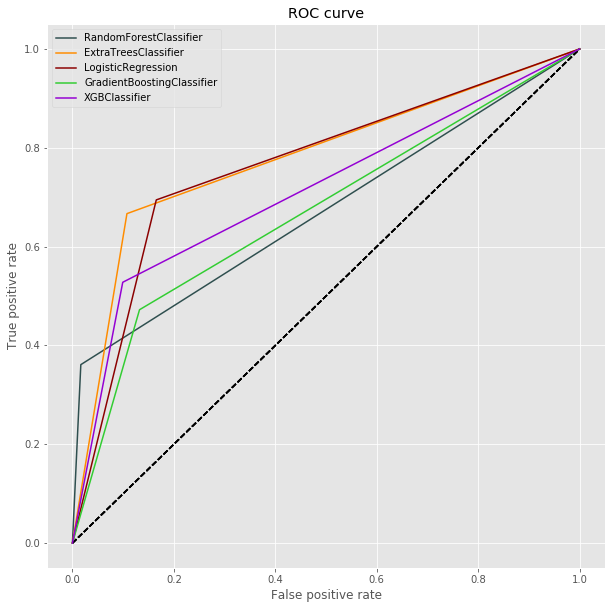

In [85]:
plt.figure(figsize=(10, 10))

_colors = ['darkslategrey', 'darkorange', 'darkred', 'limegreen', 'darkviolet']

for _row in list(range(0, len(df_results))):
    
    y_test = df_results.y_test.values[_row]
    y_predictions = df_results.y_predictions.values[_row]
    
    fp, tp, _ = roc_curve(y_test, y_predictions)
    auc = roc_auc_score(y_test, y_predictions)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fp, tp, color = _colors[_row], label = df_results.model_name[_row])
    
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'ROC curve')
plt.legend(loc = 'best')
plt.show()

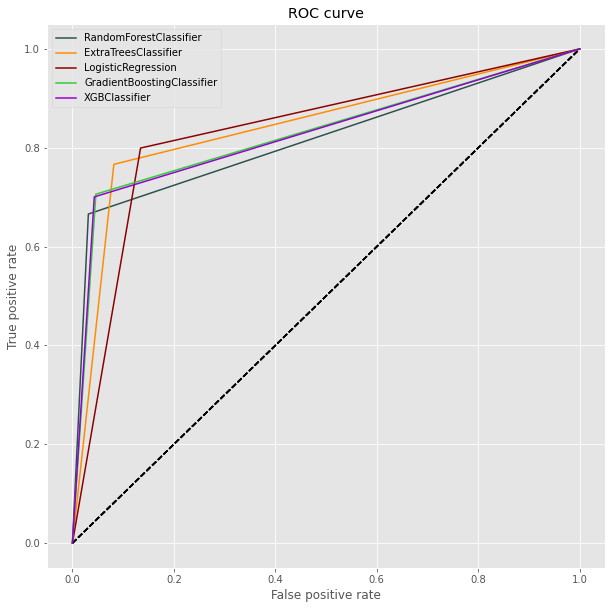

In [10]:
plt.figure(figsize=(10, 10))

_colors = ['darkslategrey', 'darkorange', 'darkred', 'limegreen', 'darkviolet']

for _row in list(range(0, len(df_results))):
    
    y_test = df_results.y_test.values[_row]
    y_predictions = df_results.y_predictions.values[_row]
    
    fp, tp, _ = roc_curve(y_test, y_predictions)
    auc = roc_auc_score(y_test, y_predictions)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fp, tp, color = _colors[_row], label = df_results.model_name[_row])
    
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'ROC curve')
plt.legend(loc = 'best')
plt.show()

#### Save the results

In [40]:
df_results.to_csv('sklearn_basic_model_results.csv', index = False)

In [86]:
# Feature importance for trees
# importances = pd.Series(model.feature_importances_, index = list(data.drop(['canceled'], axis = 1).columns)).to_frame().reset_index()
# importances.columns = ['feature', 'importance']
# importances.sort_values(by = 'importance', ascending = False)

# Gradient boosting
# importances = pd.Series(list(model.coef_[0]), index = list(data.drop(['canceled'], axis = 1).columns)).to_frame().reset_index()
# importances.columns = ['feature', 'importance']
# importances.sort_values(by = 'importance', ascending = False)

## Performs grid search for each of the previous models

In [11]:
from sklearn.preprocessing import Normalizer, RobustScaler, StandardScaler, MaxAbsScaler

from time import time

def train_grid(train_function, scaler_name):
    
    # Run the grid search
    model_result = train_function(_x, 'canceled', scaler_name)
    
    # Create and diplay the dataframe
    df_results = pd.DataFrame([model_result])
    filename = f'{train_function.__name__}.csv'
    df_results.to_csv(filename, index = False)
    print(f'{filename} saved.')
    return df_results.sort_values(['beta'], ascending = False)
    
    
# Remove binary features
features_to_normalize = list(data.drop(['canceled', 'male', 'paid'], axis = 1).columns)

_x = data.copy()
_scaler = RobustScaler()
scaler_name = _scaler.__class__.__name__
_x[features_to_normalize] = _scaler.fit_transform(_x[features_to_normalize]) 

## Logistic Regression - GridSearch 

In [12]:
df_result = train_grid(train_gs_logistic_regression, scaler_name)
df_result.head()

Fitting 3 folds for each of 1650 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:  4.7min
/home/bruno/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 3840 tasks      | elapsed:  7.3min
[Parallel(

train_gs_logistic_regression.csv saved.


,accuracy,precision,recall,auc,binary,beta,tp,fn,fp,tn,y_test,y_predictions,normalizer,params,model_name,execution_time_ms
0,0.8506,0.6321,0.7994,0.8324,0.7060,0.7592,1311,329,763,4904,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...]",RobustScaler,"{'C': 2, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 2000, 'multi_class': 'warn', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 42, 'solver': 'sag', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}",LogisticRegression,587.8732


In [15]:
df_result = train_grid(train_gs_logistic_regression, scaler_name)
df_result.head()

Fitting 3 folds for each of 1650 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 3840 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 4576 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:  9.3min finished


train_gs_logistic_regression.csv saved.


,accuracy,precision,recall,auc,binary,beta,tp,fn,fp,tn,y_test,y_predictions,normalizer,params,model_name,execution_time_ms
0,0.8506,0.6321,0.7994,0.8324,0.7060,0.7592,1311,329,763,4904,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...]",RobustScaler,"{'C': 2, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 2000, 'multi_class': 'warn', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 42, 'solver': 'sag', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}",LogisticRegression,568.3003


## Random Forest - GridSearch

In [13]:
df_result = train_grid(train_gs_random_forest, scaler_name)
df_result.head()

Fitting 3 folds for each of 6336 candidates, totalling 19008 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 3840 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 4576 tasks      | elapsed: 29.2min
/home/bruno/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory

KeyboardInterrupt: 

## Gradient Boosting - GridSearch

In [79]:
df_result = train_grid(train_gs_gradient_boosting, scaler_name)
df_result.head()

Fitting 3 folds for each of 16800 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 993 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 2337 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 4065 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 6177 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 8673 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 11553 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 14817 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 17322 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 19338 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 21546 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 23538 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 24402 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 25330 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 26322 t

train_gs_gradient_boosting.csv saved.


,accuracy,precision,recall,auc,binary,beta,tp,fn,fp,tn,y_test,y_predictions,normalizer,params,model_name,execution_time_ms
0,0.859873,0.75,0.583333,0.762741,0.65625,0.610465,21,15,7,114,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...",RobustScaler,"{'criterion': 'friedman_mse', 'init': None, 'l...",GradientBoostingClassifier,840.214908


In [14]:
df_result = train_grid(train_gs_gradient_boosting, scaler_name)
df_result.head()

Fitting 3 folds for each of 16800 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 3840 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 4576 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 5376 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 6240 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 8160 tasks      |

train_gs_gradient_boosting.csv saved.


,accuracy,precision,recall,auc,binary,beta,tp,fn,fp,tn,y_test,y_predictions,normalizer,params,model_name,execution_time_ms
0,0.8986,0.8222,0.6994,0.8278,0.7558,0.7209,1147,493,248,5419,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]",RobustScaler,"{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.25, 'loss': 'deviance', 'max_depth': 3, 'max_features': 25, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 9, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': 10, 'presort': 'auto', 'random_state': 42, 'subsample': 0.75, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}",GradientBoostingClassifier,28105.4813


## XGBoost - GridSearch

In [85]:
df_result = train_grid(train_gs_xgb, scaler_name)
df_result.head()

Fitting 3 folds for each of 11340 candidates, totalling 34020 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 3840 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 4576 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 5376 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 6240 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 8160 tasks      |

train_gs_xgb.csv saved.


,accuracy,precision,recall,auc,binary,beta,tp,fn,fp,tn,y_test,y_predictions,normalizer,params,model_name,execution_time_ms
0,0.853503,0.76,0.527778,0.739096,0.622951,0.56213,19,17,6,115,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...",RobustScaler,"{'objective': 'binary:logistic', 'base_score':...",XGBClassifier,446.990084


In [13]:
df_result = train_grid(train_gs_xgb, scaler_name)
df_result.head()

Fitting 3 folds for each of 11340 candidates, totalling 34020 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
exception calling callback for <Future at 0x7f595b64e210 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/bruno/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/bruno/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 340, in __call__
    self.parallel.dispatch_next()
  File "/home/bruno/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 769, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/bruno/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/bruno/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/bruno/anaconda3/lib/python3.7/site

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

## ExtraTrees Classifier - GridSearch

In [21]:
df_result = train_grid(train_gs_extra_trees, scaler_name)
df_result.head()

Fitting 3 folds for each of 49500 candidates, totalling 148500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 3840 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4576 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 5376 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6240 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 8160 tasks      |

train_gs_extra_trees.csv saved.


,accuracy,precision,recall,auc,binary,beta,tp,fn,fp,tn,y_test,y_predictions,normalizer,params,model_name,execution_time_ms
0,0.802548,0.580645,0.5,0.696281,0.537313,0.514286,18,18,13,108,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, ...",RobustScaler,"{'bootstrap': False, 'class_weight': 'balanced...",ExtraTreesClassifier,6186.589918


## Testing with the full dataset

In [23]:
data = pd.read_csv('sparkify_data_full_dataset_final.csv') 

pd.set_option('use_inf_as_na', True)
data = data.dropna()
data = data.drop(list(filter(lambda c: len(c) == 2, data.columns)), axis = 1)

print(data.shape)

data.head(10)

(22278, 34)


,canceled,male,paid,avg_daily_actions,avg_session_duration,n_actions,n_added_to_playlist,n_ads,n_days,n_dislikes,n_downgrades,n_errors,n_friends,n_help,n_home,n_likes,n_sess,n_settings,n_songs,n_upgrades,session_avg_actions,session_avg_added_playlist,session_avg_ads,session_avg_dislikes,session_avg_errors,session_avg_friends,session_avg_help,session_avg_home,session_avg_likes,session_avg_playback,session_avg_settings,session_avg_songs,session_avg_time_away,time_window
0,0,1,1,56.833333,8.064826,682,20,3,12,10,1,3,12,5,27,25,9,4,557,0,17.669538,0.518168,0.077725,0.259084,0.077725,0.310901,0.129542,0.699527,0.647710,1.016793,0.103634,14.430986,152.105347,1255.440278
1,1,0,1,58.166667,4.353918,349,12,2,6,2,0,1,7,1,14,10,7,1,287,1,17.434019,0.599451,0.099908,0.099908,0.049954,0.349679,0.049954,0.699359,0.499542,1.020685,0.049954,14.336858,65.024815,410.167222
2,0,1,0,14.000000,1.315119,28,0,0,2,0,0,0,1,0,3,0,2,1,22,0,18.241042,0.000000,0.000000,0.000000,0.000000,0.651466,0.000000,1.954397,0.000000,2.109316,0.651466,14.332248,298.926389,300.461389
3,0,1,0,29.500000,2.790073,531,9,30,18,6,0,0,9,1,26,21,15,1,408,0,19.514685,0.330757,1.102525,0.220505,0.000000,0.330757,0.036751,0.955521,0.771767,1.040109,0.036751,14.994334,90.768254,1297.965833
4,0,0,0,32.571429,2.471243,228,11,21,7,3,0,3,2,2,5,12,7,2,159,0,21.472296,1.035944,1.977712,0.282530,0.282530,0.188353,0.188353,0.470884,1.130121,1.039006,0.188353,14.974101,145.537407,883.842778
5,0,1,0,26.833333,3.542581,322,16,16,12,4,0,1,5,3,15,14,12,2,241,0,16.372881,0.813559,0.813559,0.203390,0.050847,0.254237,0.152542,0.762712,0.711864,0.845122,0.101695,12.254237,106.078687,1186.532222
6,1,1,0,77.227273,11.968665,1699,45,11,22,16,0,1,21,7,67,72,20,13,1407,1,17.796632,0.471365,0.115222,0.167596,0.010475,0.219970,0.073323,0.701810,0.754183,1.067419,0.136172,14.738000,53.993684,1121.347500
7,0,1,1,95.733333,13.635294,1436,27,0,15,18,1,3,18,8,53,69,11,10,1191,0,17.316621,0.325591,0.000000,0.217061,0.036177,0.217061,0.096471,0.639123,0.832066,1.106967,0.120589,14.362183,115.059500,1233.521111
8,0,1,1,57.250000,7.133694,687,19,0,12,7,0,0,12,1,35,20,9,1,569,0,16.532307,0.457225,0.000000,0.168451,0.000000,0.288774,0.024064,0.842257,0.481290,0.954952,0.024064,13.692696,139.881458,1160.606667
9,0,1,0,87.500000,6.826770,175,3,10,2,2,0,0,1,1,5,9,2,1,141,0,16.617430,0.284870,0.949567,0.189913,0.000000,0.094957,0.094957,0.474784,0.854611,0.944355,0.094957,13.388901,535.350556,545.881667


In [24]:
from sklearn.preprocessing import Normalizer, RobustScaler, StandardScaler, MaxAbsScaler

# Remove binary features
features_to_normalize = list(data.drop(['canceled', 'male', 'paid'], axis = 1).columns)

_x = data.copy()
_scaler = RobustScaler()
scaler_name = _scaler.__class__.__name__
_x[features_to_normalize] = _scaler.fit_transform(_x[features_to_normalize]) 
_train_results = []

for _train in training_methods:
    _results = _train(_x, 'canceled', scaler_name)
    _train_results.append(_results)

In [25]:
df_results = pd.DataFrame(_train_results)
df_results.sort_values(['beta'], ascending = False)

,accuracy,precision,recall,auc,binary,beta,tp,fn,fp,tn,y_test,y_predictions,normalizer,params,model_name,execution_time_ms
1,0.884586,0.742274,0.756468,0.839447,0.749304,0.753586,1345,433,467,5553,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RobustScaler,"{'bootstrap': True, 'class_weight': 'balanced'...",ExtraTreesClassifier,0.573271
2,0.832906,0.603939,0.776153,0.812910,0.679301,0.734277,1380,398,905,5115,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, ...",RobustScaler,"{'C': 1.0, 'class_weight': 'balanced', 'dual':...",LogisticRegression,1.560351
3,0.895230,0.822700,0.688976,0.822561,0.749923,0.712126,1225,553,264,5756,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RobustScaler,"{'criterion': 'friedman_mse', 'init': None, 'l...",GradientBoostingClassifier,10.696546
4,0.895871,0.838710,0.672666,0.817230,0.746567,0.700398,1196,582,230,5790,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RobustScaler,"{'objective': 'binary:logistic', 'base_score':...",XGBClassifier,0.685576
0,0.892921,0.862972,0.630484,0.800458,0.728632,0.666389,1121,657,178,5842,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RobustScaler,"{'bootstrap': True, 'class_weight': 'balanced'...",RandomForestClassifier,0.667605


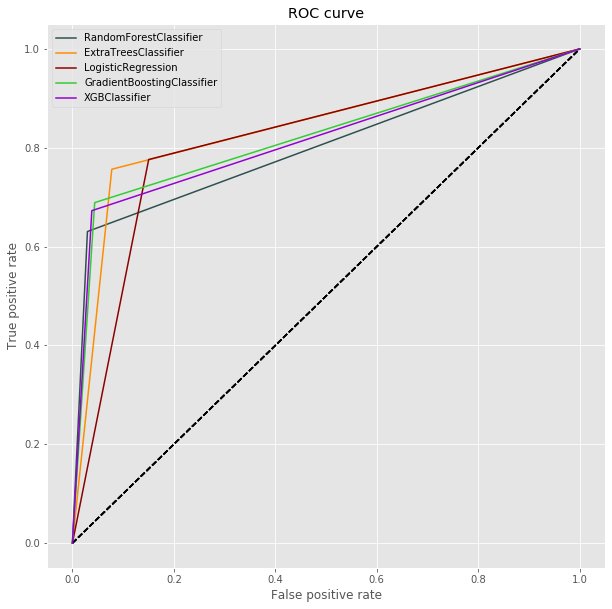

In [26]:
plt.figure(figsize=(10, 10))

_colors = ['darkslategrey', 'darkorange', 'darkred', 'limegreen', 'darkviolet']

for _row in list(range(0, len(df_results))):
    
    y_test = df_results.y_test.values[_row]
    y_predictions = df_results.y_predictions.values[_row]
    
    fp, tp, _ = roc_curve(y_test, y_predictions)
    auc = roc_auc_score(y_test, y_predictions)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fp, tp, color = _colors[_row], label = df_results.model_name[_row])
    
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'ROC curve')
plt.legend(loc = 'best')
plt.show()

## Logistic Regression - Grid Search

In [27]:
df_result = train_grid(train_gs_logistic_regression, scaler_name)
df_result.head()

Fitting 3 folds for each of 1650 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  4.1min
/home/bruno/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 3840 tasks      | elapsed: 25.2min
[Parallel(

train_gs_logistic_regression.csv saved.


,accuracy,precision,recall,auc,binary,beta,tp,fn,fp,tn,y_test,y_predictions,normalizer,params,model_name,execution_time_ms
0,0.834573,0.607774,0.773903,0.813197,0.680851,0.733788,1376,402,888,5132,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, ...",RobustScaler,"{'C': 12, 'class_weight': 'balanced', 'dual': ...",LogisticRegression,2058.382847


## Random Forest - Grid Search

In [28]:
df_result = train_grid(train_gs_random_forest, scaler_name)
df_result.head()

Fitting 3 folds for each of 6336 candidates, totalling 19008 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:  2.8min
/home/bruno/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 3840 tasks      | elapsed: 25.3min
[Parallel(

train_gs_random_forest.csv saved.


,accuracy,precision,recall,auc,binary,beta,tp,fn,fp,tn,y_test,y_predictions,normalizer,params,model_name,execution_time_ms
0,0.879328,0.717855,0.775591,0.842779,0.745607,0.763312,1379,399,542,5478,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RobustScaler,"{'bootstrap': False, 'class_weight': 'balanced...",RandomForestClassifier,11105.10889


## Gradient Boosting - Grid Search

In [29]:
df_result = train_grid(train_gs_gradient_boosting, scaler_name)
df_result.head()

Fitting 3 folds for each of 16800 candidates, totalling 50400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 3840 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 4576 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 5376 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 6240 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 8160 tasks      |

train_gs_gradient_boosting.csv saved.


,accuracy,precision,recall,auc,binary,beta,tp,fn,fp,tn,y_test,y_predictions,normalizer,params,model_name,execution_time_ms
0,0.898051,0.843947,0.67829,0.820624,0.752105,0.706006,1206,572,223,5797,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RobustScaler,"{'criterion': 'friedman_mse', 'init': None, 'l...",GradientBoostingClassifier,31649.127838


## XGBoosting - GridSearch

In [30]:
df_result = train_grid(train_gs_xgb, scaler_name)
df_result.head()

Fitting 3 folds for each of 11340 candidates, totalling 34020 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed: 27.5min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done 3840 tasks      | elapsed: 53.8min
[Parallel(n_jobs=-1)]: Done 4576 tasks      | elapsed: 63.6min
[Parallel(n_jobs=-1)]: Done 5376 tasks      | elapsed: 76.0min
[Parallel(n_jobs=-1)]: Done 6240 tasks      | elapsed: 88.0min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed: 100.7min
[Parallel(n_jobs=-1)]: Done 8160 tasks      

train_gs_xgb.csv saved.


,accuracy,precision,recall,auc,binary,beta,tp,fn,fp,tn,y_test,y_predictions,normalizer,params,model_name,execution_time_ms
0,0.899205,0.841598,0.687289,0.824542,0.756656,0.713452,1222,556,230,5790,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",RobustScaler,"{'objective': 'binary:logistic', 'base_score':...",XGBClassifier,29374.549565


## Extra Trees

In [ ]:
df_result = train_grid(train_gs_extra_trees, scaler_name)
df_result.head()

In [ ]:
df_result = train_grid(train_gs_extra_trees, scaler_name)
df_result.head()

Fitting 3 folds for each of 49500 candidates, totalling 148500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:  5.2min
/home/bruno/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 3840 tasks      | elapsed:  8.0min
[Parallel(